In [46]:
from __future__ import annotations

import operator
from pathlib import Path
from typing import TypedDict, List, Optional, Literal, Annotated

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_tavily import TavilySearch

In [47]:
from dotenv import load_dotenv
load_dotenv()

True

In [48]:
# 1) Schemas

In [49]:
class Task(BaseModel):
    id: int
    title: str

    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section.",
    )

    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=6,
        description="3–6 concrete, non-overlapping subpoints to cover.",
    )

    target_words: int = Field(..., description="Target word count (150–450).")

    tags: List[str] = Field(default_factory=list)
    requires_research: bool = False
    requires_citations: bool = False
    requires_code: bool = False

In [50]:
class Plan(BaseModel):
    blog_title: str
    audience: str
    tone: str
    blog_kind: Literal["explainer", "tutorial", "news_roundup", "comparison", "system_design"] = "explainer"
    constraints: List[str] = Field(default_factory=list)
    tasks: List[Task]


In [51]:
class EvidenceItem(BaseModel):
    title: str
    url: str
    published_at: Optional[str] = None
    snippet: Optional[str] = None
    source: Optional[str] = None

In [52]:
class RouterDecision(BaseModel):
    needs_research: bool
    mode: Literal["closed_book", "hybrid", "open_book"]
    queries: List[str] = Field(default_factory=list)

In [53]:
class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(default_factory=list)

In [54]:
class State(TypedDict):
    topic: str

    mode: str
    needs_research: bool
    queries: List[str]
    evidence: List[EvidenceItem]
    plan: Optional[Plan]

    sections: Annotated[List[tuple[int, str]], operator.add]
    final: str



In [55]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [56]:
llm.invoke("Good Morning")

AIMessage(content='Good morning! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 37, 'total_tokens': 48, 'completion_time': 0.011582788, 'completion_tokens_details': None, 'prompt_time': 0.003449202, 'prompt_tokens_details': None, 'queue_time': 0.048684268, 'total_time': 0.01503199}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c6abe-9934-75e3-8ebb-9e672000741f-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 37, 'output_tokens': 11, 'total_tokens': 48})

In [57]:
# 3) Router

In [58]:
ROUTER_SYSTEM = """You are a routing controller for a technical blog generation system.

Your ONLY job is to decide whether external web research is required BEFORE planning.

Decision criteria:

Use closed_book if:
- Topic is conceptual and evergreen.
- Correctness does NOT depend on recent events, rankings, pricing, releases.

Use hybrid if:
- Topic is mostly evergreen BUT benefits from recent examples or model versions.

Use open_book if:
- Topic references time (e.g., "2026", "latest", "this week", "state of").
- Topic depends on current releases, benchmarks, funding, regulation.

STRICT RULES:
- If topic includes a year >= 2025, default to open_book.
- If hybrid or open_book, generate 4–8 specific search queries.
- Queries must contain concrete entities (model names, companies, benchmarks).
- Avoid generic queries like "AI news".

Output strictly matching RouterDecision schema.
No explanation.
"""

def router_node(state: State) -> dict:
    decider = llm.with_structured_output(RouterDecision)

    decision = decider.invoke(
        [
            SystemMessage(content=ROUTER_SYSTEM),
            HumanMessage(content=f"Topic: {state['topic']}"),
        ]
    )

    return {
        "needs_research": decision.needs_research,
        "mode": decision.mode,
        "queries": decision.queries,
    }


def route_next(state: State) -> str:
    return "research" if state["needs_research"] else "orchestrator"


In [59]:
def _tavily_search(query: str, max_results: int = 5) -> List[dict]:
    tool = TavilySearch(max_results=max_results)
    return tool.invoke({"query": query}) or []


RESEARCH_SYSTEM = """You are a strict research extraction module.

Convert raw search results into EvidenceItem objects.

Hard Rules:
- Only include items with valid http/https URLs.
- Do NOT invent URLs.
- Do NOT fabricate publication dates.
- If no date provided, set published_at=null.
- Deduplicate strictly by exact URL.
- Keep snippets under 300 characters.
- Prefer official docs, company blogs, reputable tech media.

If results are irrelevant or weak, return empty list.

Output strictly matching EvidencePack schema.
No commentary.
"""


def research_node(state: State) -> dict:

    raw_results = []
    for q in state.get("queries", [])[:8]:
        raw_results.extend(_tavily_search(q, max_results=6))

    if not raw_results:
        return {"evidence": []}

    extractor = llm.with_structured_output(EvidencePack)

    pack = extractor.invoke(
        [
            SystemMessage(content=RESEARCH_SYSTEM),
            HumanMessage(content=f"Raw results:\n{raw_results}"),
        ]
    )

    dedup = {}
    for e in pack.evidence:
        if e.url:
            dedup[e.url] = e

    return {"evidence": list(dedup.values())}


In [60]:
# -----------------------------
# 5) Orchestrator (Plan)
# -----------------------------
ORCH_SYSTEM = """You are a senior AI systems engineer and technical writer.

Produce a high-signal, implementation-oriented blog outline.

Constraints:
- 6–8 sections only.
- Include:
    * 1 architecture/system design section
    * 1 minimal working example section (requires_code=True)
    * 1 failure modes / limitations section
    * 1 performance/cost/scaling section (if relevant)

Section Requirements:
Each section must include:
- Concrete developer-focused goal
- 3–6 actionable bullets
- 150–450 word target

Quality Bar:
- No fluff or marketing language.
- Assume ML engineer audience.
- Avoid repetitive conceptual sections.

Mode Handling:
- closed_book → evergreen structure.
- hybrid → mark sections using fresh info as requires_research=True.
- open_book:
    * blog_kind = "news_roundup"
    * All sections summarize events + implications.
    * Cite evidence-backed items only.

Output strictly matching Plan schema.
No commentary.
"""


def orchestrator_node(state: State) -> dict:
    planner = llm.with_structured_output(Plan)

    plan = planner.invoke(
        [
            SystemMessage(content=ORCH_SYSTEM),
            HumanMessage(
                content=(
                    f"Topic: {state['topic']}\n"
                    f"Mode: {state['mode']}\n"
                    f"Evidence:\n{[e.model_dump() for e in state.get('evidence', [])][:20]}"
                )
            ),
        ]
    )

    return {"plan": plan}

In [61]:
def fanout(state: State):
    return [
        Send(
            "worker",
            {
                "task": task.model_dump(),
                "topic": state["topic"],
                "mode": state["mode"],
                "plan": state["plan"].model_dump(),
                "evidence": [e.model_dump() for e in state.get("evidence", [])],
            },
        )
        for task in state["plan"].tasks
    ]

In [62]:
# -----------------------------
# 7) Worker (write one section)
# -----------------------------
WORKER_SYSTEM = """You are a senior AI engineer writing ONE section of a technical blog.

Output ONLY valid Markdown.

Structure:
- Start with ## <Section Title>
- Cover ALL bullets in order.
- Stay within ±10% of target words.

Rules:
- No fluff.
- Precise terminology.
- Short paragraphs.
- Use numbered steps for workflows.
- Code under 30 lines if required.

Grounding:
If mode == open_book:
  - Every factual claim must include citation.
  - Format: ([Source](URL))
  - Only use provided URLs.
  - If unsupported → write: "Not found in provided sources."

If requires_code == true:
  - Include minimal working example.
  - Must be syntactically valid.

No extra commentary.
"""


def worker_node(payload: dict) -> dict:

    task = Task(**payload["task"])
    plan = Plan(**payload["plan"])

    bullets_text = "\n- " + "\n- ".join(task.bullets)

    section_md = llm.invoke(
        [
            SystemMessage(content=WORKER_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog title: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Topic: {payload['topic']}\n"
                    f"Mode: {payload['mode']}\n\n"
                    f"Section title: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n"
                )
            ),
        ]
    ).content.strip()

    return {"sections": [(task.id, section_md)]}


In [63]:
# 8) Reducer (merge + save)

def reducer_node(state: State) -> dict:
    plan = state["plan"]

    ordered_sections = [
        md for _, md in sorted(state["sections"], key=lambda x: x[0])
    ]

    body = "\n\n".join(ordered_sections).strip()
    final_md = f"# {plan.blog_title}\n\n{body}\n"

    filename = f"{plan.blog_title}.md"
    Path(filename).write_text(final_md, encoding="utf-8")

    return {"final": final_md}

In [64]:
g = StateGraph(State)

g.add_node("router", router_node)
g.add_node("research", research_node)
g.add_node("orchestrator", orchestrator_node)
g.add_node("worker", worker_node)
g.add_node("reducer", reducer_node)

g.add_edge(START, "router")
g.add_conditional_edges(
    "router",
    route_next,
    {"research": "research", "orchestrator": "orchestrator"},
)

g.add_edge("research", "orchestrator")
g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

app = g.compile()

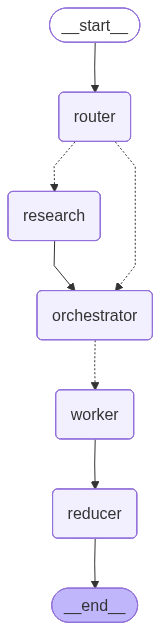

In [65]:
app

In [66]:
def run(topic: str):
    return app.invoke(
        {
            "topic": topic,
            "mode": "",
            "needs_research": False,
            "queries": [],
            "evidence": [],
            "plan": None,
            "sections": [],
            "final": "",
        }
    )

In [67]:
run("Evolution of LLMs till 2026")

{'topic': 'Evolution of LLMs till 2026',
 'mode': 'open_book',
 'needs_research': True,
 'queries': ['LLM development 2025',
  'Latest LLM models 2026',
  'Comparison of LLMs and their applications',
  'LLM advancements in natural language processing 2026'],
 'evidence': [],
 'plan': Plan(blog_title='Evolution of LLMs till 2026', audience='ML engineers', tone='technical', blog_kind='news_roundup', constraints=[], tasks=[Task(id=1, title='Introduction to LLM Evolution', goal='Understand the recent advancements in LLMs', bullets=['Discuss the key developments in LLM architecture', 'Highlight the importance of LLMs in AI research', 'Explain the role of LLMs in natural language processing'], target_words=200, tags=['LLMs', 'AI research'], requires_research=True, requires_citations=True, requires_code=False), Task(id=2, title='Recent Breakthroughs in LLMs', goal='Identify the latest breakthroughs in LLMs', bullets=['Summarize the key findings of recent LLM research papers', 'Discuss the imp